In [2]:
import numpy as np
import os, sys, librosa
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
import pandas as pd
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4

print(os.getcwd())


/workspace/src


In [46]:
def compute_sm_from_filename(fn_wav, L=21, H=5, L_smooth=16, tempo_rel_set=np.array([1]),
                             shift_set=np.array([0]), strategy='relative', scale=True, thresh=0.15,
                             penalty=0.0, binarize=False):
    """Compute an SSM

    Notebook: C4/C4S2_SSM-Thresholding.ipynb

    Args:
        fn_wav (str): Path and filename of wav file
        L (int): Length of smoothing filter (Default value = 21)
        H (int): Downsampling factor (Default value = 5)
        L_smooth (int): Length of filter (Default value = 16)
        tempo_rel_set (np.ndarray):  Set of relative tempo values (Default value = np.array([1]))
        shift_set (np.ndarray): Set of shift indices (Default value = np.array([0]))
        strategy (str): Thresholding strategy (see :func:`libfmp.c4.c4s2_ssm.compute_sm_ti`)
            (Default value = 'relative')
        scale (bool): If scale=True, then scaling of positive values to range [0,1] (Default value = True)
        thresh (float): Treshold (meaning depends on strategy) (Default value = 0.15)
        penalty (float): Set values below treshold to value specified (Default value = 0.0)
        binarize (bool): Binarizes final matrix (positive: 1; otherwise: 0) (Default value = False)

    Returns:
        x (np.ndarray): Audio signal
        x_duration (float): Duration of audio signal (seconds)
        X (np.ndarray): Feature sequence
        Fs_feature (scalar): Feature rate
        S_thresh (np.ndarray): SSM
        I (np.ndarray): Index matrix
    """
    # Waveform
    Fs = 22050
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_duration = x.shape[0] / Fs

    # Chroma Feature Sequence and SSM (10 Hz)
    C = librosa.feature.chroma_stft(y=x, sr=Fs, tuning=0, norm=2, hop_length=2205, n_fft=4410)
    Fs_C = Fs / 2205

    # Chroma Feature Sequence and SSM
    X, Fs_feature = libfmp.c3.smooth_downsample_feature_sequence(C, Fs_C, filt_len=L, down_sampling=H)
    X = libfmp.c3.normalize_feature_sequence(X, norm='2', threshold=0.001)

    # Compute SSM
    S, I = libfmp.c4.compute_sm_ti(X, X, L=L_smooth, tempo_rel_set=tempo_rel_set, shift_set=shift_set, direction=2)
    S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy,
                                          scale=scale, penalty=penalty, binarize=binarize)
    return x, x_duration, X, Fs_feature, S_thresh, I

In [65]:
# Waveform
#fn_wav = os.path.join('..', 'audio', 'RS500', '29 - The Beatles - Help.mp3')
fn_wav = "/workspace/audio/Boomy500/Blockchain - boomy.mp3"
print(fn_wav)
tempo_rel_set = libfmp.c4.compute_tempo_rel_set( 0.66, 1.5, 5)
x, x_duration, X, Fs_X, S, I = compute_sm_from_filename(fn_wav, L=81, H=10, L_smooth=1, thresh=1)

# Visualization
# Since we're omitting annotations, we don't use ann_frames or color_ann in the plotting
# fig, ax = libfmp.c4.plot_feature_ssm(X, 1, S, 1, [], x_duration*Fs_X,
#             label='Time (frames)', clim_X=[0,1], clim=[0,1], 
#             title=f'Feature rate: {Fs_X:0.0f} Hz')

/workspace/audio/Boomy500/Blockchain - boomy.mp3


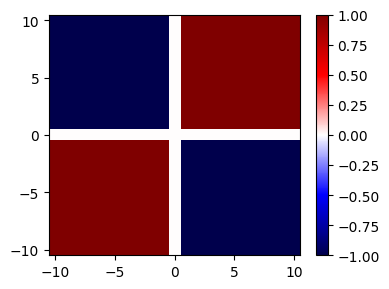

In [66]:
def compute_kernel_checkerboard_box(L):
    """Compute box-like checkerboard kernel [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size 2*L+1

    Returns:
        kernel (np.ndarray): Kernel matrix of size (2*L+1) x (2*L+1)
    """
    axis = np.arange(-L, L+1)
    kernel = np.outer(np.sign(axis), np.sign(axis))
    return kernel

L = 10
kernel = compute_kernel_checkerboard_box(L)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', origin='lower', 
           extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

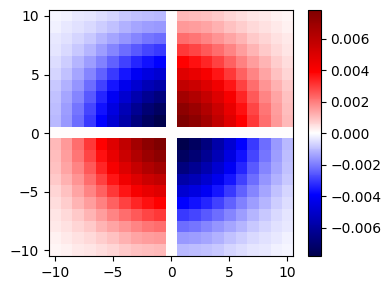

In [67]:
@jit(nopython=True)
def compute_kernel_checkerboard_gaussian(L, var=1, normalize=True):
    """Compute Guassian-like checkerboard kernel [FMP, Section 4.4.1].
    See also: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size M=2*L+1
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 1.0)
        normalize (bool): Normalize kernel (Default value = True)

    Returns:
        kernel (np.ndarray): Kernel matrix of size M x M
    """
    taper = np.sqrt(1/2) / (L * var)
    axis = np.arange(-L, L+1)
    gaussian1D = np.exp(-taper**2 * (axis**2))
    gaussian2D = np.outer(gaussian1D, gaussian1D)
    kernel_box = np.outer(np.sign(axis), np.sign(axis))
    kernel = kernel_box * gaussian2D
    if normalize:
        kernel = kernel / np.sum(np.abs(kernel))
    return kernel

L = 10
var = 0.5
kernel = compute_kernel_checkerboard_gaussian(L, var)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', origin='lower', 
           extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

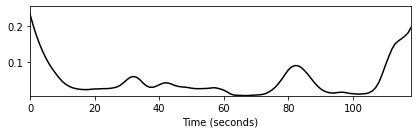

In [68]:
# @jit(nopython=True)
def compute_novelty_ssm(S, kernel=None, L=10, var=0.5, exclude=False):
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        S (np.ndarray): SSM
        kernel (np.ndarray): Checkerboard kernel (if kernel==None, it will be computed) (Default value = None)
        L (int): Parameter specifying the kernel size M=2*L+1 (Default value = 10)
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 0.5)
        exclude (bool): Sets the first L and last L values of novelty function to zero (Default value = False)

    Returns:
        nov (np.ndarray): Novelty function
    """
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2*L + 1
    nov = np.zeros(N)
    # np.pad does not work with numba/jit
    S_padded = np.pad(S, L, mode='constant')

    for n in range(N):
        # Does not work with numba/jit
        nov[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    if exclude:
        right = np.min([L, N])
        left = np.max([0, N-L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov

L_kernel = 20
nov = compute_novelty_ssm(S, L=L_kernel, exclude=False)   
fig, ax, line = libfmp.b.plot_signal(nov, Fs = Fs_X, color='k') 

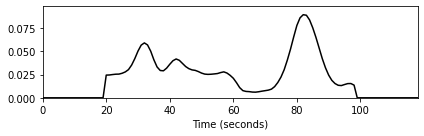

In [69]:
L_kernel = 20
nov = compute_novelty_ssm(S, L=L_kernel, exclude=True)        
fig, ax, line = libfmp.b.plot_signal(nov, Fs=Fs_X, color='k')

# Removed the line that plots annotations overlay
plt.tight_layout()


[32 82]


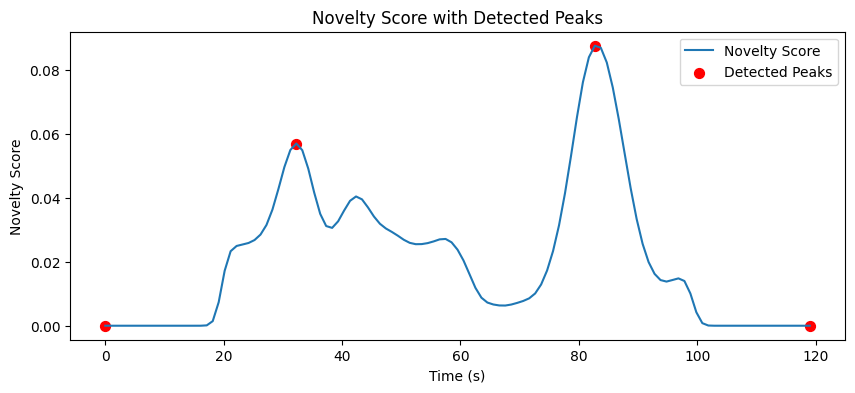

In [70]:
import scipy 

nov_smoothed = scipy.ndimage.gaussian_filter1d(nov, sigma=1)
peaks = librosa.util.peak_pick(nov_smoothed, pre_max=3, post_max=3, pre_avg=3, post_avg=3, delta=0.005, wait=10)
print(peaks)

# 'Fs_feature' should be the feature rate or equivalent to ensure correct time scaling
times = np.linspace(0, len(nov_smoothed) / Fs_feature, len(nov_smoothed))

# Ensure 'peaks' contains integer indices
peaks = peaks.astype(int)  # Ensures peaks are of integer type, though usually not necessary
# Add start and end indices
peaks = np.hstack(([0], peaks, [len(nov) - 1]))

plt.figure(figsize=(10, 4))
plt.plot(times, nov_smoothed, label='Novelty Score')
plt.scatter(times[peaks], nov_smoothed[peaks], color='r', s=50, label='Detected Peaks')  # Plot peaks
plt.xlabel('Time (s)')
plt.ylabel('Novelty Score')
plt.legend()
plt.title('Novelty Score with Detected Peaks')
plt.show()

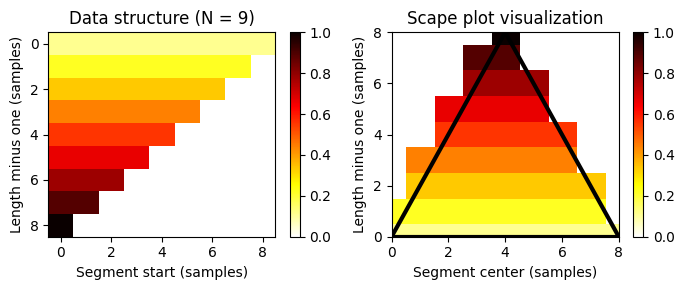

In [71]:
def visualize_scape_plot(SP, Fs=1, ax=None, figsize=(4, 3), title='',
                         xlabel='Center (seconds)', ylabel='Length (seconds)', interpolation='nearest'):
    """Visualize scape plot

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        SP: Scape plot data (encodes as start-duration matrix)
        Fs: Sampling rate (Default value = 1)
        ax: Used axes (Default value = None)
        figsize: Figure size (Default value = (4, 3))
        title: Title of figure (Default value = '')
        xlabel: Label for x-axis (Default value = 'Center (seconds)')
        ylabel: Label for y-axis (Default value = 'Length (seconds)')
        interpolation: Interpolation value for imshow (Default value = 'nearest')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()
    N = SP.shape[0]
    SP_vis = np.zeros((N, N))
    for length_minus_one in range(N):
        for start in range(N-length_minus_one):
            center = start + length_minus_one//2
            SP_vis[length_minus_one, center] = SP[length_minus_one, start]

    extent = np.array([-0.5, (N-1)+0.5, -0.5, (N-1)+0.5]) / Fs
    im = plt.imshow(SP_vis, cmap='hot_r', aspect='auto', origin='lower', extent=extent, interpolation=interpolation)
    x = np.asarray(range(N))
    x_half_lower = x/2
    x_half_upper = x/2 + N/2 - 1/2
    plt.plot(x_half_lower/Fs, x/Fs, '-', linewidth=3, color='black')
    plt.plot(x_half_upper/Fs, np.flip(x, axis=0)/Fs, '-', linewidth=3, color='black')
    plt.plot(x/Fs, np.zeros(N)/Fs, '-', linewidth=3, color='black')
    plt.xlim([0, (N-1) / Fs])
    plt.ylim([0, (N-1) / Fs])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.colorbar(im, ax=ax)
    return fig, ax, im

N = 9
SP = np.zeros((N,N))
for k in range(N):
    for s in range(N-k):
        length = k + 1
        SP[k, s]= length/N  

plt.figure(figsize=(7,3))
ax = plt.subplot(121)
plt.imshow(SP, cmap='hot_r', aspect='auto') 
ax.set_title('Data structure (N = %d)'%N)
ax.set_xlabel('Segment start (samples)')
ax.set_ylabel('Length minus one (samples)')
plt.colorbar()  

ax = plt.subplot(122)
fig, ax, im = visualize_scape_plot(SP, Fs=1, ax=ax, title='Scape plot visualization', 
                xlabel='Segment center (samples)', ylabel='Length minus one (samples)')

/tmp/ipykernel_278674/745655040.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(labels))  # Adjust len(labels) as needed


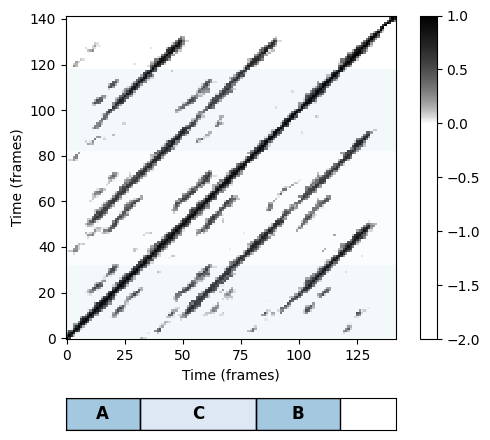

In [72]:
import os
import libfmp.c4

# Assuming compute_sm_from_filename and normalization_properties_ssm are defined elsewhere

# File paths
fn_wav = os.path.join('..', 'audio', 'RS500', '29 - The Beatles - Help.mp3')

# Compute self-similarity matrix from filename
tempo_rel_set = libfmp.c4.compute_tempo_rel_set(0.66, 1.5, 5)
penalty = -2
x, x_duration, X, Fs_feature, S, I = compute_sm_from_filename(fn_wav, L=21, H=10, 
                        L_smooth=8, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh=0.15)
S = libfmp.c4.normalization_properties_ssm(S)

# Calculate segment lengths
segment_lengths = np.diff(peaks)

# Sort segments by length to assign labels
sorted_indices = np.argsort(segment_lengths)
labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"  # Extend this string if you have more than 26 segments

# Assign labels based on sorted order of lengths
label_assignments = {index: labels[i] for i, index in enumerate(sorted_indices)}

# Now, create ann_frames with labels based on their lengths
ann_frames = [(peaks[i], peaks[i+1], label_assignments[i]) for i in range(len(peaks)-1)]
# Color definitions: 
colormap = plt.cm.get_cmap('tab20', len(labels))  # Adjust len(labels) as needed

# Assign colors to labels
color_ann = {label: colormap(i)[:3] + (0.4,) for i, label in enumerate(labels)}

# Plotting the self-similarity matrix with annotations
cmap_penalty = libfmp.c4.colormap_penalty(penalty=penalty)
fig, ax, im = libfmp.c4.plot_ssm_ann(S, ann_frames, Fs=1, color_ann=color_ann, cmap=cmap_penalty, 
                       xlabel='Time (frames)', ylabel='Time (frames)')


In [73]:
# @jit(nopython=True)
def compute_fitness_scape_plot(S):
    """Compute scape plot for fitness and other measures

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        S (np.ndarray): Self-similarity matrix

    Returns:
        SP_all (np.ndarray): Vector containing five different scape plots for five measures
            (fitness, score, normalized score, coverage, normlized coverage)
    """
    N = S.shape[0]
    SP_fitness = np.zeros((N, N))
    SP_score = np.zeros((N, N))
    SP_score_n = np.zeros((N, N))
    SP_coverage = np.zeros((N, N))
    SP_coverage_n = np.zeros((N, N))

    for length_minus_one in range(N):
        for start in range(N-length_minus_one):
            S_seg = S[:, start:start+length_minus_one+1]
            D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
            path_family = libfmp.c4.compute_optimal_path_family(D)
            fitness, score, score_n, coverage, coverage_n, path_family_length = libfmp.c4.compute_fitness(
                path_family, score, N)
            SP_fitness[length_minus_one, start] = fitness
            SP_score[length_minus_one, start] = score
            SP_score_n[length_minus_one, start] = score_n
            SP_coverage[length_minus_one, start] = coverage
            SP_coverage_n[length_minus_one, start] = coverage_n
    SP_all = [SP_fitness, SP_score, SP_score_n, SP_coverage, SP_coverage_n]
    return SP_all

SP_all = compute_fitness_scape_plot(S)

In [74]:
def seg_max_sp(SP):
    """Return segment with maximal value in SP

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        SP (np.ndarray): Scape plot

    Returns:
        seg (tuple): Segment ``(start_index, end_index)``
    """
    N = SP.shape[0]
    # value_max = np.max(SP)
    arg_max = np.argmax(SP)
    ind_max = np.unravel_index(arg_max, [N, N])
    seg = [ind_max[1], ind_max[1]+ind_max[0]]
    return seg

def plot_seg_in_sp(ax, seg, S=None, Fs=1):
    """Plot segment and induced segements as points in SP visualization

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        ax: Axis for image
        seg: Segment ``(start_index, end_index)``
        S: Self-similarity matrix (Default value = None)
        Fs: Sampling rate (Default value = 1)
    """
    if S is not None:
        S_seg = S[:, seg[0]:seg[1]+1]
        D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
        path_family = libfmp.c4.compute_optimal_path_family(D)
        segment_family, coverage = libfmp.c4.compute_induced_segment_family_coverage(path_family)
        length = segment_family[:, 1] - segment_family[:, 0] + 1
        center = segment_family[:, 0] + length//2
        ax.scatter(center/Fs, length/Fs, s=64, c='white', zorder=9999)
        ax.scatter(center/Fs, length/Fs, s=16, c='lime', zorder=9999)
    length = seg[1] - seg[0] + 1
    center = seg[0] + length//2
    ax.scatter(center/Fs, length/Fs, s=64, c='white', zorder=9999)
    ax.scatter(center/Fs, length/Fs, s=16, c='blue', zorder=9999)

def plot_sp_ssm(SP, seg, S, ann, color_ann=[], title='', figsize=(5, 4)):
    """Visulization of SP and SSM

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        SP: Scape plot
        seg: Segment ``(start_index, end_index)``
        S: Self-similarity matrix
        ann: Annotation
        color_ann: color scheme used for annotations (Default value = [])
        title: Title of figure (Default value = '')
        figsize: Figure size (Default value = (5, 4))
    """
    float_box = libfmp.b.FloatingBox()
    fig, ax, im = visualize_scape_plot(SP, figsize=figsize, title=title,
                                       xlabel='Center (frames)', ylabel='Length (frames)')
    plot_seg_in_sp(ax, seg, S)
    float_box.add_fig(fig)

    penalty = np.min(S)
    cmap_penalty = libfmp.c4.colormap_penalty(penalty=penalty)
    fig, ax, im = libfmp.c4.plot_ssm_ann_optimal_path_family(
        S, ann, seg, color_ann=color_ann, fontsize=8, cmap=cmap_penalty, figsize=(4, 4),
        ylabel='Time (frames)')
    float_box.add_fig(fig)
    float_box.show()
    
def check_segment(seg, S):
    """Prints properties of segments with regard to SSM ``S``

    Notebook: C4/C4S3_ScapePlot.ipynb

    Args:
        seg (tuple): Segment ``(start_index, end_index)``
        S (np.ndarray): Self-similarity matrix

    Returns:
         path_family (list): Optimal path family
    """
    N = S.shape[0]
    S_seg = S[:, seg[0]:seg[1]+1]
    D, score = libfmp.c4.compute_accumulated_score_matrix(S_seg)
    path_family = libfmp.c4.compute_optimal_path_family(D)
    fitness, score, score_n, coverage, coverage_n, path_family_length = libfmp.c4.compute_fitness(
                path_family, score, N)
    segment_family, coverage2 = libfmp.c4.compute_induced_segment_family_coverage(path_family)
    print('Segment (alpha):', seg)
    print('Length of segment:', seg[-1]-seg[0]+1)
    print('Length of feature sequence:', N)
    print('Induced segment path family:\n', segment_family)
    print('Fitness: %0.10f' % fitness)
    print('Score: %0.10f' % score)
    print('Normalized score: %0.10f' % score_n)
    print('Coverage: %d, %d' % (coverage, coverage2))
    print('Normalized coverage: %0.10f' % coverage_n)
    print('Length of all paths of family: %d' % path_family_length)
    return path_family



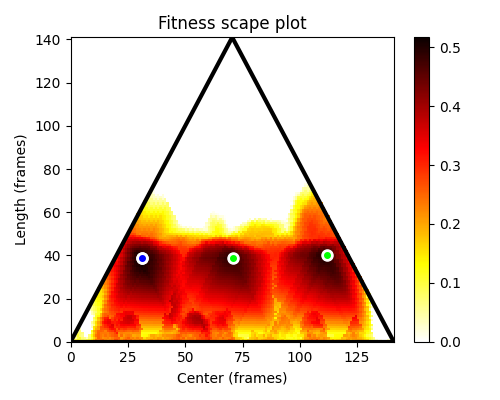
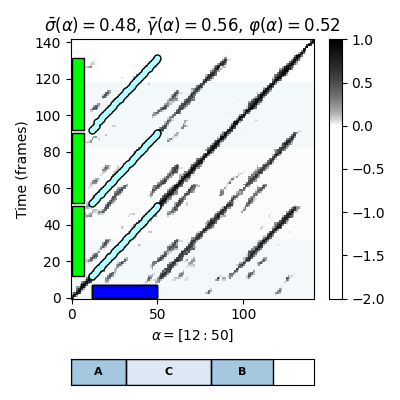

Segment (alpha): [12, 50]
Length of segment: 39
Length of feature sequence: 142
Induced segment path family:
 [[ 12  50]
 [ 52  90]
 [ 92 131]]
Fitness: 0.5170335220
Score: 95.5011916488
Normalized score: 0.4829161679
Coverage: 118, 118
Normalized coverage: 0.5563380282
Length of all paths of family: 117


In [75]:
SP_all = compute_fitness_scape_plot(S)
figsize=(5,4)
SP = SP_all[0]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Fitness scape plot', figsize=figsize)
path_family = check_segment(seg, S)


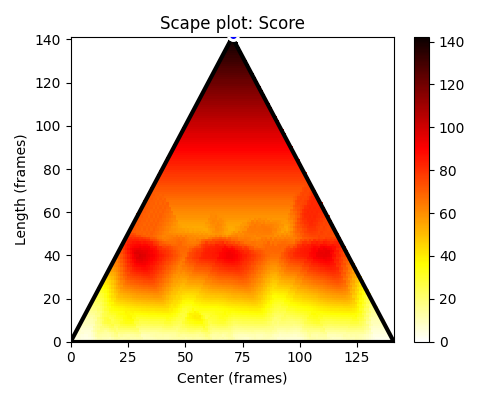
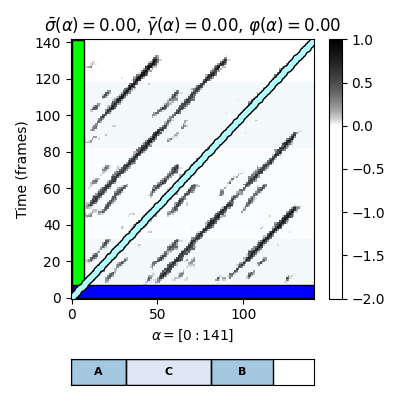

Segment (alpha): [0, 141]
Length of segment: 142
Length of feature sequence: 142
Induced segment path family:
 [[  0 141]]
Fitness: 0.0000000000
Score: 142.0000000000
Normalized score: 0.0000000000
Coverage: 142, 142
Normalized coverage: 0.0000000000
Length of all paths of family: 142


In [76]:
SP = SP_all[1]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Score', figsize=figsize)
path_family = check_segment(seg, S)


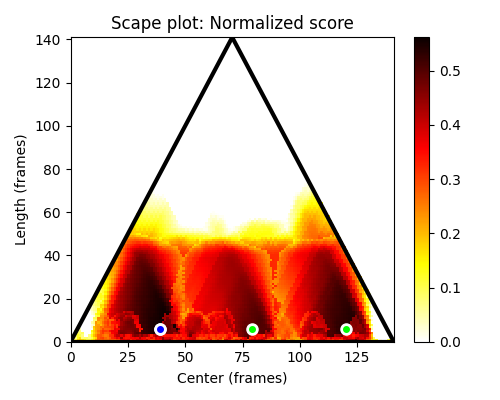
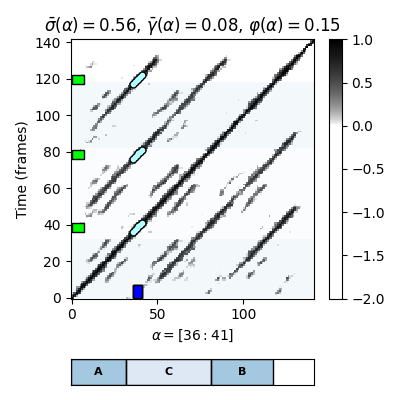

Segment (alpha): [36, 41]
Length of segment: 6
Length of feature sequence: 142
Induced segment path family:
 [[ 36  41]
 [ 76  81]
 [117 122]]
Fitness: 0.1469067817
Score: 16.1081456377
Normalized score: 0.5615636465
Coverage: 18, 18
Normalized coverage: 0.0845070423
Length of all paths of family: 18


In [81]:
SP = SP_all[2]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Normalized score', figsize=figsize)
path_family = check_segment(seg, S)


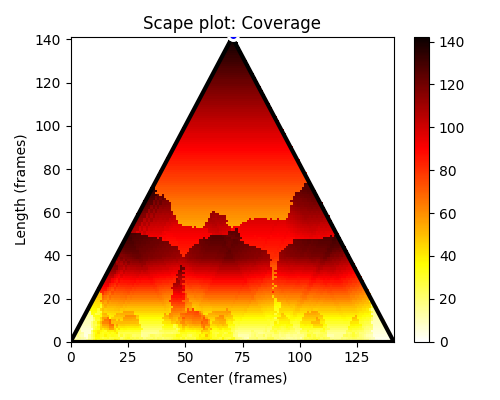
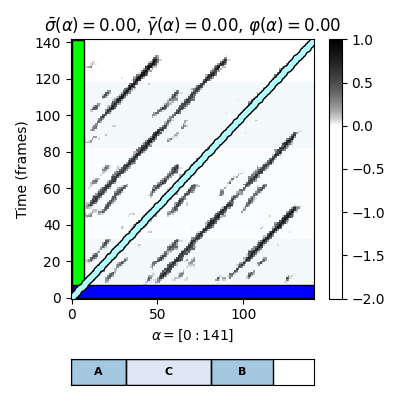

Segment (alpha): [0, 141]
Length of segment: 142
Length of feature sequence: 142
Induced segment path family:
 [[  0 141]]
Fitness: 0.0000000000
Score: 142.0000000000
Normalized score: 0.0000000000
Coverage: 142, 142
Normalized coverage: 0.0000000000
Length of all paths of family: 142


In [82]:
SP = SP_all[3]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Coverage', figsize=figsize)
path_family = check_segment(seg, S)


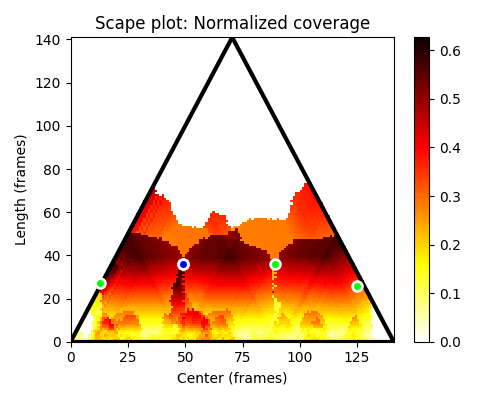
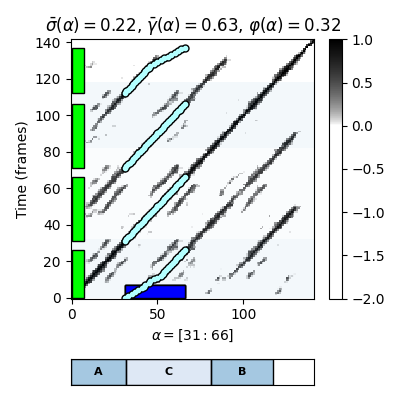

Segment (alpha): [31, 66]
Length of segment: 36
Length of feature sequence: 142
Induced segment path family:
 [[  0  26]
 [ 31  66]
 [ 71 106]
 [112 137]]
Fitness: 0.3239199518
Score: 63.2993753881
Normalized score: 0.2183950031
Coverage: 125, 125
Normalized coverage: 0.6267605634
Length of all paths of family: 125


In [83]:
SP = SP_all[4]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Normalized coverage', figsize=figsize)
path_family = check_segment(seg, S)

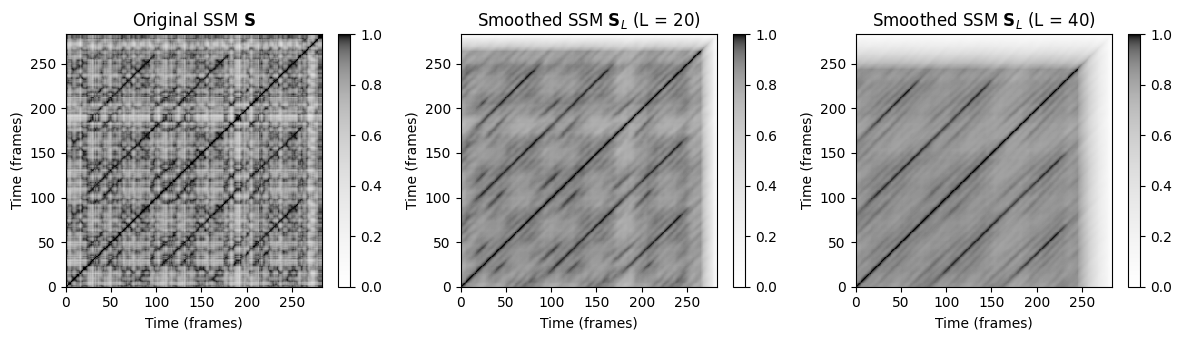

In [9]:
@jit(nopython=True)
def filter_diag_sm(S, L):
    """Path smoothing of similarity matrix by forward filtering along main diagonal

    Notebook: C4/C4S2_SSM-PathEnhancement.ipynb

    Args:
        S (np.ndarray): Similarity matrix (SM)
        L (int): Length of filter

    Returns:
        S_L (np.ndarray): Smoothed SM
    """
    N = S.shape[0]
    M = S.shape[1]
    S_L = np.zeros((N, M))
    S_extend_L = np.zeros((N + L, M + L))
    S_extend_L[0:N, 0:M] = S
    for pos in range(0, L):
        S_L = S_L + S_extend_L[pos:(N + pos), pos:(M + pos)]
    S_L = S_L / L
    return S_L

def subplot_matrix_colorbar(S, fig, ax, title='', Fs=1,
                            xlabel='Time (seconds)', ylabel='Time (seconds)',
                            clim=None, xlim=None, ylim=None, cmap=None, interpolation='nearest'):
    """Visualization function for showing zoomed sections of matrices

    Notebook: C4/C4S2_SSM-PathEnhancement.ipynb

    Args:
        S: Similarity matrix (SM)
        fig: Figure handle
        ax: Axes handle
        title: Title for figure (Default value = '')
        Fs: Feature rate (Default value = 1)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Time (seconds)')
        clim: Color limits (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for x-axis (Default value = None)
        cmap: Colormap for imshow (Default value = None)
        interpolation: Interpolation value for imshow (Default value = 'nearest')

    Returns:
        im: Imshow handle
    """
    if cmap is None:
        cmap = libfmp.b.compressed_gray_cmap(alpha=-100)
    len_sec = S.shape[0] / Fs
    extent = [0, len_sec, 0, len_sec]
    im = ax.imshow(S, aspect='auto', extent=extent, cmap=cmap,  origin='lower', interpolation=interpolation)
    fig.sca(ax)
    fig.colorbar(im)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)
    return im

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
subplot_matrix_colorbar(S, fig, ax[0], clim=[0,1], ylabel='Time (frames)', xlabel='Time (frames)',
                     title=r'Original SSM $\mathbf{S}$')
L = 20
S_L = filter_diag_sm(S, L)
subplot_matrix_colorbar(S_L, fig, ax[1], clim=[0,1], ylabel='Time (frames)', xlabel='Time (frames)',
                     title=r'Smoothed SSM $\mathbf{S}_{L}$ (L = %d)'%L)
L_long = 40
S_L_long = filter_diag_sm(S, L_long)
subplot_matrix_colorbar(S_L_long, fig, ax[2], clim=[0,1], ylabel='Time (frames)', xlabel='Time (frames)',
                     title=r'Smoothed SSM $\mathbf{S}_{L}$ (L = %d)'%L_long)

plt.tight_layout()
plt.show()